In [2]:
import torch, pickle
from torch.utils.data import Dataset, DataLoader
from utils.PreProc_Data.DataProc import StackedSequenceDataset
import numpy as np
from utils.Eval_MZA import Eval_MZA
import matplotlib.pyplot as plt
import pandas as pd
import os

In [4]:
torch.cuda.empty_cache()
exp_dir   = "Trained_Models/Cluster_Models/KS_Num_Obstest_withseqmodel_N256_dt0p001_L6"  #Experiment Directory
exp_name  = "sl32_nhu40_numobs16_bs16_lr5e-5"             #One of the experiment names

models = []
for exp_name in os.listdir(exp_dir):
    if exp_name != "results" and exp_name != ".DS_Store":
        print(exp_name)
        models.append(Eval_MZA(exp_dir, exp_name))
models


sl8_nhu40_numobs16_bs16_lr5e-5
sl16_nhu40_numobs16_bs16_lr5e-5
sl64_nhu40_numobs32_bs16_lr5e-5


OutOfMemoryError: CUDA out of memory. Tried to allocate 7.25 GiB (GPU 0; 15.75 GiB total capacity; 8.05 GiB already allocated; 3.00 GiB free; 8.09 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

: 

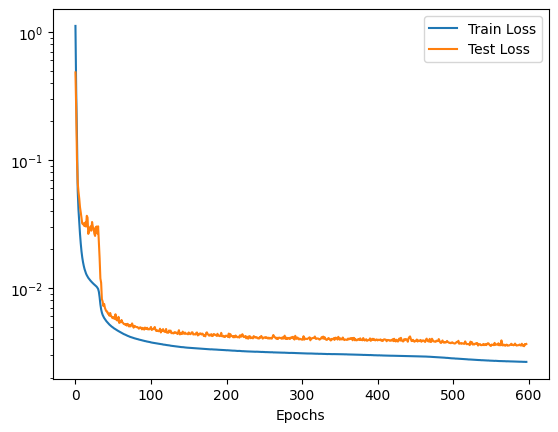

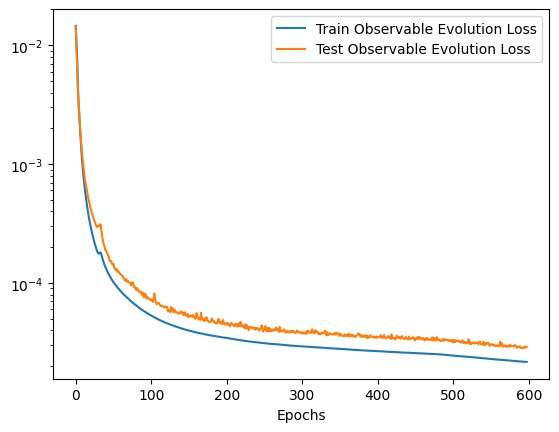

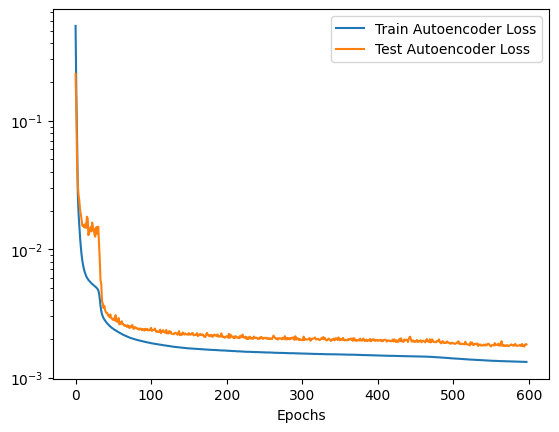

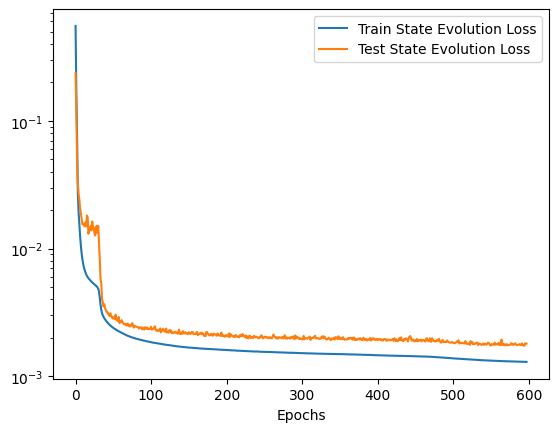

In [3]:
#plot learning curves
eval_mza.plot_learning_curves()

In [4]:
epoch_num = 500
eval_mza.load_weights(epoch_num)

In [5]:
eval_mza.train_size = 0.95
eval_mza.create_dataset(mode = "Test")
# del eval_mza.lp_data 
# torch.cuda.empty_cache()
# del eval_mza.train_dataset
# del eval_mza.train_dataloader
dataset = eval_mza.test_dataset
num_trajs = eval_mza.test_num_trajs
x_nn_hat, Phi_nn_hat, Phi_nn, State_MSE = eval_mza.predict_onestep(dataset, num_trajs)

print(x_nn_hat.shape, Phi_nn_hat.shape, Phi_nn.shape)

#Plotting one step prediction



Test_Shape:  (1, 9900, 256)
torch.Size([1, 9900, 16]) torch.Size([1, 9900, 256]) torch.Size([1, 9900, 256])


/home/pg221/anaconda3/envs/KS/lib/python3.10/site-packages/torch/nn/modules/rnn.py:774: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at /opt/conda/conda-bld/pytorch_1670525552843/work/aten/src/ATen/native/cudnn/RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


Text(0, 0.5, 'MSE')

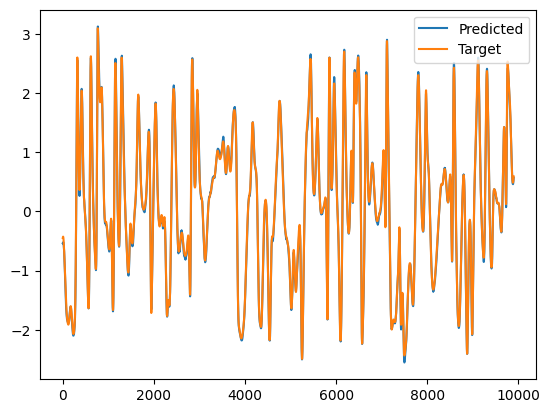

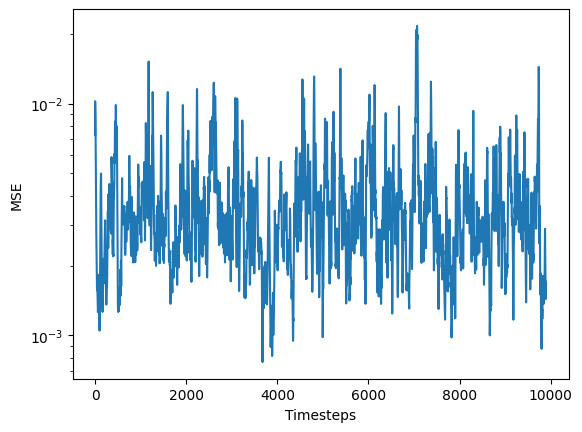

In [6]:
for i in range (1):
    plt.figure()
    plt.plot(Phi_nn_hat.cpu().numpy()[i,:,0], label = "Predicted")
    plt.plot(Phi_nn.cpu().numpy()[i,:,0], label = "Target")
    plt.legend()

plt.figure()
plt.semilogy(State_MSE.cpu().numpy())
plt.xlabel("Timesteps")
plt.ylabel("MSE")

In [7]:
#multistep prediction
timesteps = 1000
initial_conditions = Phi_nn[:,0].to(eval_mza.device)
x_hat, Phi_hat = eval_mza.predict_multistep(initial_conditions, timesteps)

print(x_hat.shape, Phi_hat.shape)


torch.Size([1, 1001, 16]) torch.Size([1, 1001, 256])


In [8]:
eval_mza.deactivate_seqmodel

False

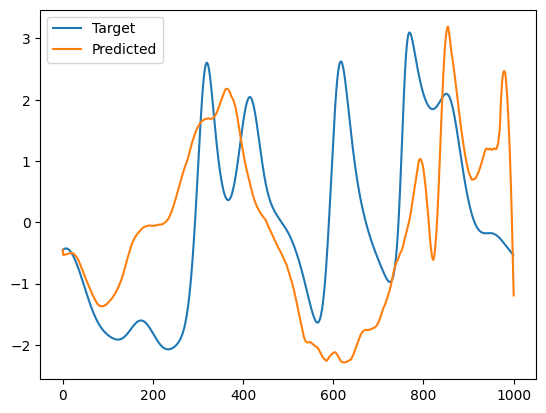

In [9]:
for i in range (1):
    plt.figure()
    plt.plot(Phi_nn.cpu().numpy()[i,:timesteps,0], '-', label = "Target")
    plt.plot(Phi_hat.cpu().numpy()[i,:,0], '-', label = "Predicted")
    plt.legend()



torch.Size([1, 9900, 256]) torch.Size([1, 1001, 256])


Text(0, 0.5, 'MSE')

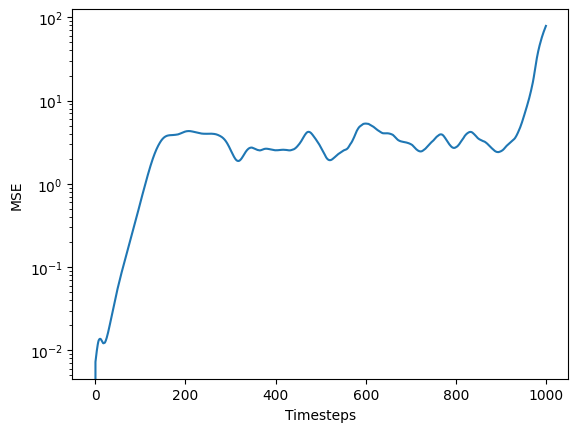

In [10]:
print(Phi_nn.shape, Phi_hat.shape)
State_MSE_multistep = Eval_MZA.state_mse(Phi_nn[:,:timesteps],Phi_hat[:,:timesteps])
plt.figure()
plt.semilogy(State_MSE_multistep.detach().cpu().numpy())
plt.xlabel("Timesteps")
plt.ylabel("MSE")

Text(0.5, 0, 'Epochs')

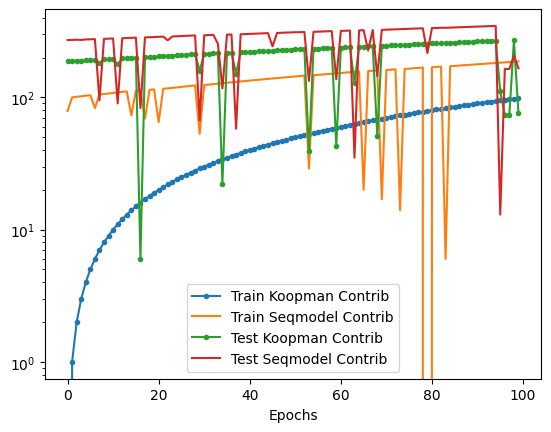

In [15]:
plt.figure()
plt.semilogy(df['epoch'],df['Train_koop_ptg'], '.-',label="Train Koopman Contrib")
plt.semilogy(df['epoch'],df['Train_seqmodel_ptg'], label="Train Seqmodel Contrib")

plt.semilogy(df['epoch'], df['Test_koop_ptg'], '.-',label="Test Koopman Contrib")
plt.semilogy(df['epoch'], df['Test_seqmodel_ptg'], label="Test Seqmodel Contrib")

plt.legend()
# plt.savefig(self.exp_dir+'/'+self.exp_name+"/out_log/")
plt.xlabel("Epochs")

<Figure size 640x480 with 0 Axes>

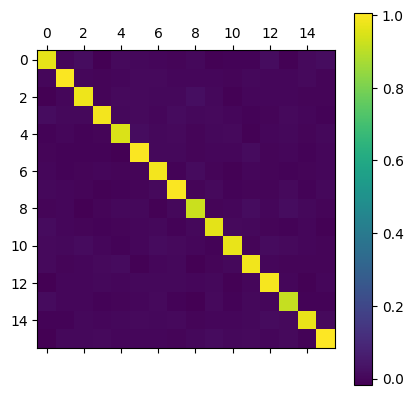

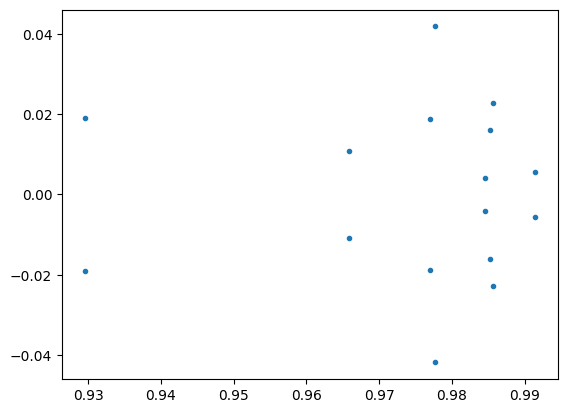

In [42]:
mat = eval_mza.model.koopman.getKoopmanMatrix()
mat = mat.detach().cpu().numpy()
w, v = np.linalg.eig(mat)

idx = w.argsort()[::-1]
w = w[idx]
v = v[:,idx]

plt.figure()
plt.matshow(mat)
plt.colorbar()

plt.figure()
plt.plot(np.real(w), np.imag(w), ".")

In [43]:
print(w)

[0.9914712+0.00552632j 0.9914712-0.00552632j 0.9856538+0.02271575j
 0.9856538-0.02271575j 0.9852751+0.01613129j 0.9852751-0.01613129j
 0.9845055+0.00399704j 0.9845055-0.00399704j 0.9776434+0.0418263j
 0.9776434-0.0418263j  0.9769968+0.01882195j 0.9769968-0.01882195j
 0.9658504+0.01091512j 0.9658504-0.01091512j 0.9295203+0.01905324j
 0.9295203-0.01905324j]


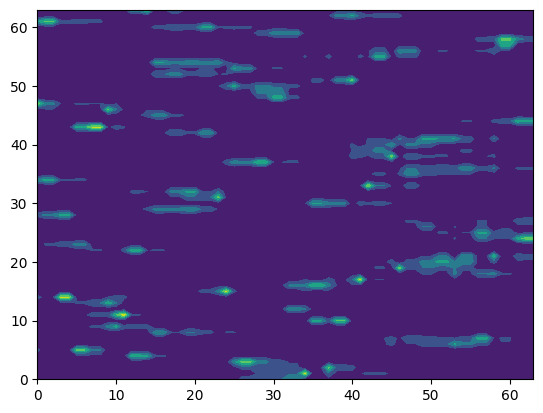

In [56]:
plt.contourf(abs(v))